In [1]:
%tensorflow_version 1.x
!pip install keras==2.1.0

TensorFlow 1.x selected.
  Using cached https://files.pythonhosted.org/packages/bf/c2/b0c2ece713e754d1692aa432ad682751cd1ad6abf7500a534558b1fbfbe7/Keras-2.1.0-py2.py3-none-any.whl
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
%cd
  
!git clone --quiet https://github.com/matterport/Mask_RCNN.git

/root
fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [3]:
%cd ~/Mask_RCNN

!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

/root/Mask_RCNN
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/utils.

In [4]:
%cd ~/Mask_RCNN

!cp ~/Mask_RCNN/samples/balloon/balloon.py ./lesion.py

!sed -i -- 's/balloon/lesion/g' lesion.py
!sed -i -- 's/Balloon/Lesion/g' lesion.py
!sed -i -- 's/epochs=30/epochs=100/g' lesion.py

/root/Mask_RCNN


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd ~/Mask_RCNN

!python lesion.py train --dataset='/content/drive/My Drive/images/' --weights=coco

/root/Mask_RCNN
Using TensorFlow backend.
Weights:  coco
Dataset:  /content/drive/My Drive/images/
Logs:  /logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_l

In [7]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import lesion

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

custom_WEIGHTS_PATH = sorted(glob.glob("/logs/*/mask_rcnn_*.h5"))[-1]

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

config = lesion.LesionConfig()
custom_DIR = os.path.join(ROOT_DIR, '/content/drive/My Drive/images/')

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
  
# Load validation dataset
dataset = lesion.LesionDataset()
dataset.load_lesion(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Using TensorFlow backend.



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  /logs/lesion20200808T1909/mask_rcnn_lesion_0040.h5






Re-starting from epoch 40


<module 'mrcnn.visualize' from '/root/Mask_RCNN/mrcnn/visualize.py'>

image ID: lesion.xray31.jpg (0) /content/drive/My Drive/images/val/xray31.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (9,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (9, 4)                min:  194.00000  max:  790.00000  int32
gt_mask                  shape: (1024, 1024, 9)       min:    0.00000  max:    1.00000  bool
image ID: lesion.xray32.jpg (1) /content/drive/My Drive/images/val/xray32.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 1024, 1024, 3

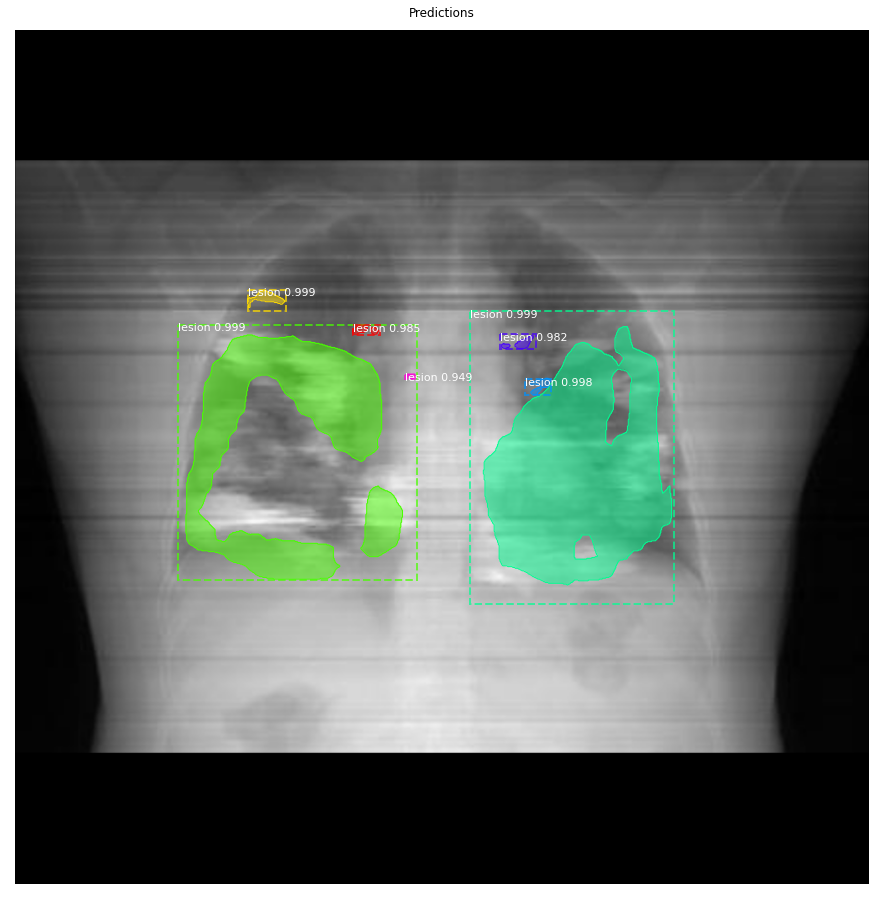

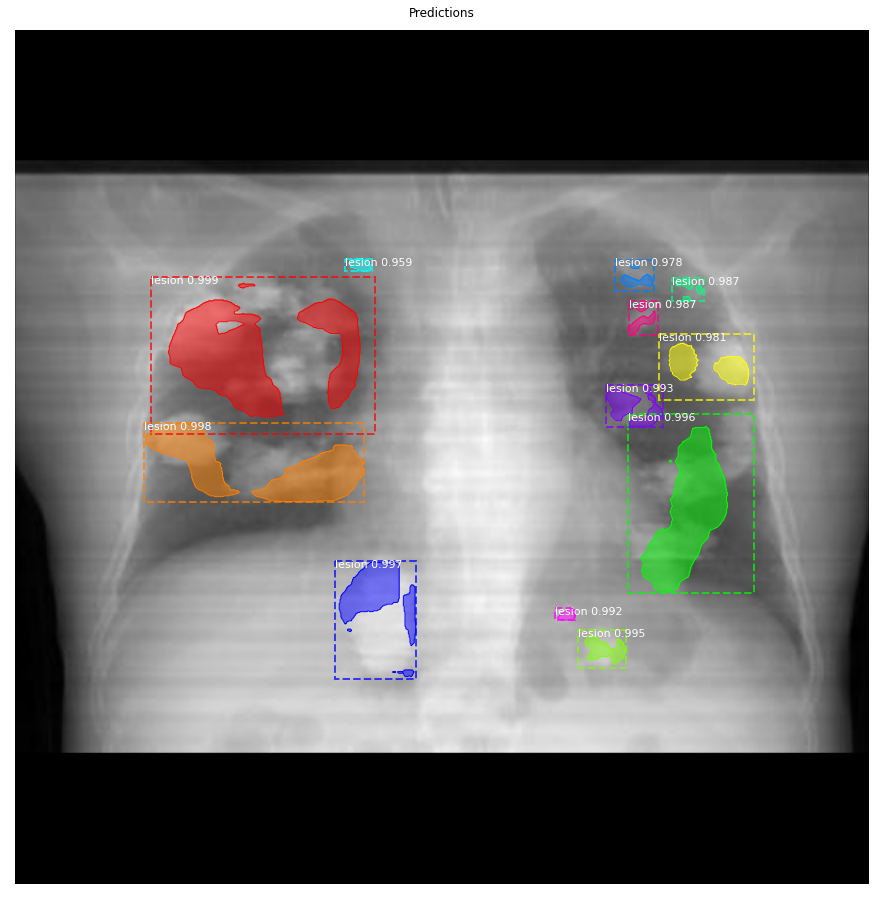

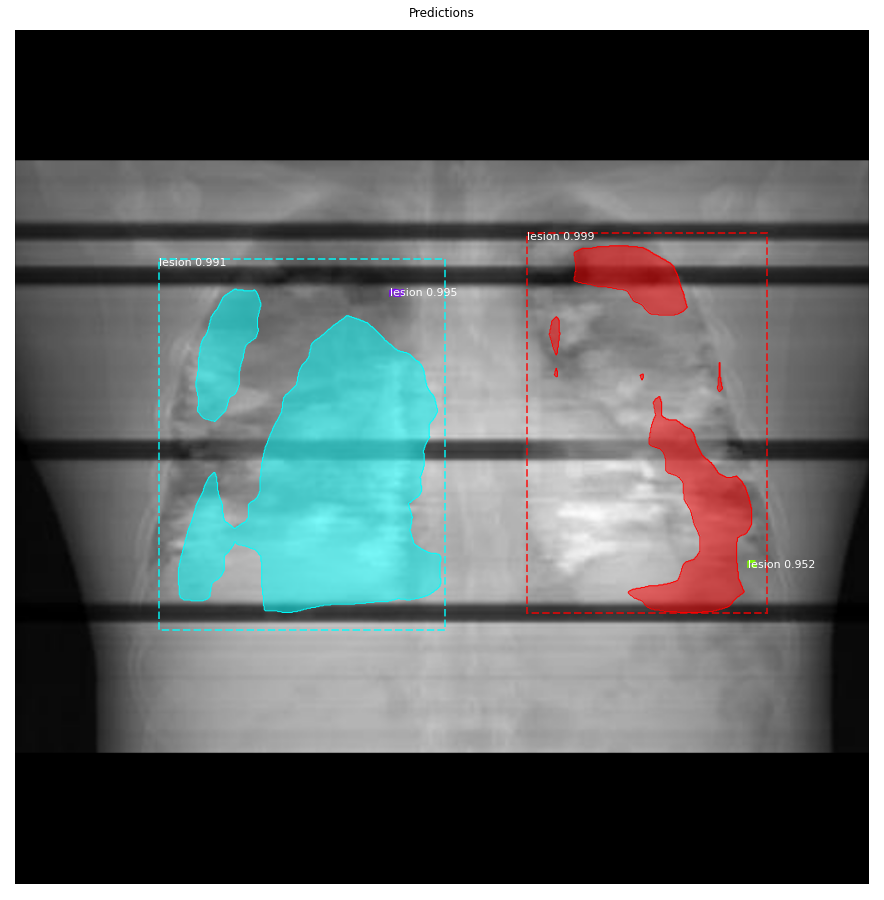

In [8]:
#image_id = random.choice(dataset.image_ids)
for image_id in dataset.image_ids:
  image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
  info = dataset.image_info[image_id]
  print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                         dataset.image_reference(image_id)))

  # Run object detection
  results = model.detect([image], verbose=1)

  # Display results
  ax = get_ax(1)
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              dataset.class_names, r['scores'], ax=ax,
                              title="Predictions")
  log("gt_class_id", gt_class_id)
  log("gt_bbox", gt_bbox)
  log("gt_mask", gt_mask)